### Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time as time_lib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import OneCycleLR

from torch.utils.data import Subset

In [2]:
#If the code is run on a machine with cuda access, the simulations will be done there and hence accelerated
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Fixing the configuration for the plots
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 10

In [4]:
def set_seed(seed):
    random.seed(seed)              # Python random module
    np.random.seed(seed)           # Numpy random module
    torch.manual_seed(seed)        # PyTorch CPU random seed
    torch.cuda.manual_seed(seed)   # PyTorch GPU random seed (if using a GPU)
    torch.cuda.manual_seed_all(seed)  # For all GPUs (if using multiple GPUs)
    torch.backends.cudnn.deterministic = True  # Ensures reproducibility in CUDA operations
    torch.backends.cudnn.benchmark = False     # Disables optimizations that might make results non-deterministic

# Set the seed to a specific value
set_seed(10)

### Download and organise the dataset

To have be able to train our model quickly on our local machine, we can restrict the size of the training and test sets. This can be done by fixing the values `train_size` and `test_size` in the method `get_data` below.

In [5]:
def get_data(batch_size=128, train_size=30000, test_size=1000):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Download Fashion MNIST dataset
    train_data_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_data_full = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


    # Reduce dataset size
    train_indices = np.random.choice(len(train_data_full), train_size, replace=False)
    test_indices = np.random.choice(len(test_data_full), test_size, replace=False)
    
    train_data = Subset(train_data_full, train_indices)
    test_data = Subset(test_data_full, test_indices)

    # Inspect the reduced dataset
    print(f"Reduced training set size: {len(train_data)}")
    print(f"Reduced test set size: {len(test_data)}")
    print(f"Image shape: {train_data[0][0].shape}")
    print(f"Image classes: {train_data_full.classes}")

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

    return train_data, test_data, train_loader, test_loader, train_data_full.classes


In [6]:
batch_size = 512
train_data,test_data,train_loader,test_loader, class_names = get_data(batch_size=batch_size)

Reduced training set size: 30000
Reduced test set size: 1000
Image shape: torch.Size([1, 28, 28])
Image classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Visualise the dataset

We now plot `num_samples` random images from the training set, and display the class to which they belong.

In [7]:
def plot_samples(train_data, class_names, num_samples=5):
    
    indices = np.random.choice(len(train_data), num_samples, replace=False)

    plt.rcParams["figure.figsize"] = (4.5, 2)

    fig, axes = plt.subplots(1, num_samples) 

    for i, idx in enumerate(indices):
        image, label = train_data[idx] 
        ax = axes[i]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(class_names[label])
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("examplesMNIST.pdf",bbox_inches="tight")
    plt.show()

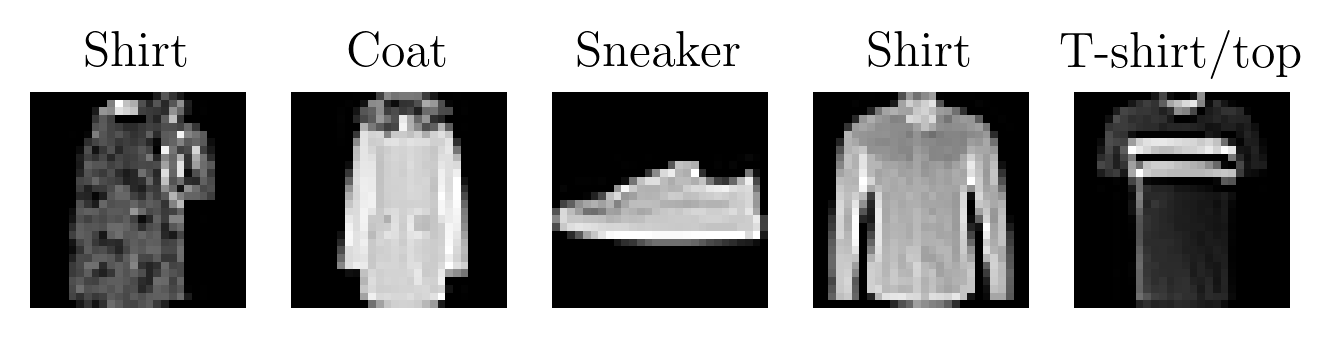

In [8]:
plot_samples(train_data,class_names)

### Definition of the neural network architectures

#### ResNet

This `ResNet` architecture consists of several key components and layers designed to process and classify images:

1. **Input Layer**:
   - The network starts with a lifting layer, `lift`, which includes a `Conv2d` layer that lifts the input channel to a larger number of intermediate channels (`int_channels=8`). This is followed by a `MaxPool2d` layer to downsample the input spatial dimensions by a factor of 2. This is done to make the model training faster.

2. **Residual Blocks**:
   - The core of the network is a sequence of residual blocks defined by the `ResidualBlock` class. Each `ResidualBlock` contains:
     - Two convolutional layers (`linearA` and `linearB`), both with a kernel size of 3, padding of 1, and the same number of intermediate channels.
     - A ReLU activation function (`nonlin`) applied after the first convolution.
     - A residual connection that adds the input `x` to the output of the second convolution layer.
   - The residual blocks are stacked in a sequence, with `n_layers=4` residual blocks applied in succession, followed by a `MaxPool2d` layer that further downscales the spatial dimensions.

3. **Projection Layer**:
   - After processing through the residual blocks, the output is flattened and fed into a fully connected `Linear` layer that maps to the final number of classes (`n_classes=10`). This layer produces the final predictions of the network.

4. **Forward Pass**:
   - The `forward` method first applies the `lift` layer to the input. The result is passed through each block in `blocks`, which contains the sequence of residual blocks and pooling. Finally, the output is passed through the `project` layer to produce the final classification output.

This architecture is a simplified residual network that uses a series of residual connections to facilitate gradient flow and prevent vanishing gradients, with pooling layers for spatial downsampling and a final fully connected layer for classification.


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, int_channels):
        super().__init__()
        self.linearA = nn.Conv2d(
                            int_channels,
                            int_channels,
                            kernel_size=3,
                            padding=1,
                            device=device,
                        )
        self.linearB = nn.Conv2d(
                            int_channels,
                            int_channels,
                            kernel_size=3,
                            padding=1,
                            device=device,
                        )
        self.nonlin = nn.ReLU()

    def forward(self, x):
        return x + self.linearB(self.nonlin(self.linearA(x)))

class ResNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=10,
        device=None
    ):
        super().__init__()

        self.int_channels = 8
        self.n_layers = 4

        self.name = "resnet"

        self.lift = nn.Sequential(
            nn.Conv2d(in_channels, self.int_channels, (1, 1), device=device),
            nn.MaxPool2d((2, 2))
        )

        self.blocks = nn.ModuleList()

        self.blocks.append(
            nn.Sequential(
                *[
                    ResidualBlock(
                        int_channels=self.int_channels
                    )
                    for _ in range(self.n_layers)
                ],
                nn.MaxPool2d((2, 2))
            )
        )
        self.project = nn.Sequential(
            *[
                nn.Flatten(),
                nn.Linear(self.int_channels*7**2, n_classes, device=device)
            ]
        )

    def forward(self, x):
        z = self.lift(x)
        for block in self.blocks:
            z = block(z)
        return self.project(z)

#### Non-expansive network

This code defines two functions, `power_method` and `compute_spectral_norm`, which together can be used to compute the spectral norm of a convolutional layer.

1. **`power_method`**:
   - This function implements the power iteration method to approximate the largest singular value (spectral norm) of a linear operator.
   - **Parameters**:
     - `A`: A function representing the linear operator.
     - `A_t`: A function representing the transpose (adjoint) of the linear operator.
     - `u_init`: An initial vector for the power iteration.
     - `k`: The number of power iterations to perform (default is 1).
   - **Process**:
     - The function initialises `u` with `u_init` and iteratively applies `A` and `A_t` to update `u`.
     - After each iteration, it normalises `u` and calculates an approximation of the spectral norm `sigma` using the Euclidean norm of `u`.
   - **Returns**:
     - The approximate spectral norm `sigma` and the normalised vector `u`.

2. **`compute_spectral_norm`**:
   - This function uses `power_method` to compute the spectral norm of a convolutional layer (`conv`).
   - **Parameters**:
     - `conv`: A convolutional layer (e.g., `torch.nn.Conv2d`) whose spectral norm is to be computed.
     - `u_init`: An optional initial vector for the power iteration. If not provided, a random vector with the same shape as the input is used.
     - `im_size`: The shape of the input image (default is (1, 28, 28)).
     - `k`: The number of power iterations (default is 1).
   - **Process**:
     - If `u_init` is `None`, it initialises `u_init` as a random tensor with the specified `im_size`.
     - It then calls `power_method` with:
       - `A` as a function that performs `conv2d` using `conv.weight`.
       - `A_t` as a function that performs `conv_transpose2d` using `conv.weight`.
   - **Returns**:
     - The spectral norm of the convolutional layer, computed using the power method, and the associated right singular vector.


In [10]:
def power_method(A, A_t, u_init, k=1):
    u = u_init
    for i in range(k):
        v = A(u)
        u = A_t(v)
        sigma = torch.sqrt(torch.sum(u * u))
        u /= torch.sqrt(torch.sum(u**2))
    return torch.sqrt(sigma), u

def compute_spectral_norm(conv, u_init=None, im_size=(1, 28, 28), k=1):
    if u_init is None:
        with torch.no_grad():
            u_init = torch.randn(1, *im_size).to(conv.weight.device)
    u_init = u_init.to(conv.weight.device)
    with torch.no_grad():
        return power_method(lambda u: torch.nn.functional.conv2d(u, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                lambda v: torch.nn.functional.conv_transpose2d(v, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                u_init, k)

This code defines two classes, `NonExpansiveBlock` and `NonExpansiveNet`, which implement a network architecture with residual layers constrained to be non-expansive.

1. **`NonExpansiveBlock`**:
   - This class represents a single non-expansive block.
   - **Parameters**:
     - `int_channels`: The number of intermediate channels expected to characterise the input tensor.
     - `dt`: A time-step parameter used to control the update magnitude.
     - `S`: The number of substeps to perform within the block with the same vector field.
   - **Layers**:
     - `linear`: A `Conv2d` layer with a kernel size of 3 and padding of 1.
     - `nl`: A `ReLU` nonlinearity applied to the output of the convolution.
   - **Forward Pass**:
     - In the `forward` method, the block iteratively updates the input `x` by doing `S` substeps with the explicit Euler method.

2. **`NonExpansiveNet`**:
   - This class represents the full network, which stacks multiple `NonExpansiveBlock` instances for feature extraction, followed by a projection layer for classification.
   - **Parameters**:
     - `in_channels`: Number of input channels (default is 1).
     - `n_classes`: Number of output classes for classification (default is 10).
     - `device`: Device to run the network on.
     - `T`: Total time parameter that determines the `dt` for each layer.
   - **Attributes**:
     - `int_channels`: Number of intermediate channels in each block, set to 8.
     - `n_layers`: Number of non-expansive blocks, set to 4.
     - `lift`: Initial `Conv2d` layer followed by `MaxPool2d` to downsample the input.
     - `blocks`: A list of sequential blocks, each containing multiple `NonExpansiveBlock` instances and followed by `MaxPool2d` for further downsampling.
     - `project`: A fully connected layer for the final classification output after flattening.
     - `sing_vectors`: A list to store the singular vectors used in spectral norm calculations for each block.
   - **Scaling Update**:
     - The `updateScalings` method computes the spectral norm for each convolution layer in `NonExpansiveBlock` using `compute_spectral_norm`, adjusts the number of iterations `S` in each block based on the spectral norm, and ensures non-expansive properties.
   - **Forward Pass**:
     - The input is first lifted through the `lift` layer, passed through each block in `blocks` for feature extraction, and then fed into the `project` layer to produce the final classification output.

The parameter `S` is initialised to all ones, but is then update while training the network. To have a faster training procedure, we only do one iteration of the power method per each training iterate. To still get an accurate approximation of the spectral norm, we warm start the calculation of the singular vectors at the network initialisation, doing 100 iterations of the power method.

In [11]:
class NonExpansiveBlock(nn.Module):
    def __init__(self, int_channels, dt, S):
        super(NonExpansiveBlock, self).__init__()

        self.linear = nn.Conv2d(
                            int_channels,
                            int_channels,
                            kernel_size=3,
                            padding=1,
                            device=device,
                        )
        self.nl = nn.ReLU()
        self.dt = dt
        self.S = S
    def forward(self, x):
        A = self.linear
        for _ in range(self.S):
            x = x - self.dt/self.S * F.conv_transpose2d(self.nl((A(x))), A.weight, padding=1, stride=1)
        return x

class NonExpansiveNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=10,
        device=None,
        T = 1
    ):
        super().__init__()

        self.int_channels = 8
        self.n_layers = 4
        
        self.lift = nn.Sequential(
            nn.Conv2d(in_channels, self.int_channels, (1, 1), device=device),
            nn.MaxPool2d((2, 2))
        )

        self.name = "nonexpansive"

        self.T = T
        self.dt = self.T / self.n_layers

        self.S = torch.ones(self.n_layers,dtype=torch.int)

        self.blocks = nn.ModuleList()
        
        self.blocks.append(
            nn.Sequential(
                *[
                    NonExpansiveBlock(
                        int_channels=self.int_channels,
                        dt=self.dt,
                        S=self.S[i]
                    )
                    for i in range(self.n_layers)
                ],
                nn.MaxPool2d((2, 2))
            )
        )
        self.project = nn.Sequential(
            *[
                nn.Flatten(),
                nn.Linear(self.int_channels*7**2, n_classes, device=device)
            ]
        )

        self.sing_vectors = []
        for i in range(self.n_layers):
            _, sing_vec = compute_spectral_norm(self.blocks[0][i].linear,im_size=(self.int_channels,14,14),k=100)
            self.sing_vectors.append(sing_vec)
    
    def updateScalings(self,k=1):
        with torch.no_grad():
            for i in range(self.n_layers):
                A = self.blocks[0][i].linear
                normA, self.sing_vectors[i] = compute_spectral_norm(A,im_size=(self.int_channels,14,14),u_init=self.sing_vectors[i],k=k)
                threshold = 2/(normA**2)
                self.S[i] = math.ceil(self.dt/threshold)
        
    def forward(self, x):
        z = self.lift(x)
        for block in self.blocks:
            z = block(z)
        
        return self.project(z)

### Training the model

The `train` function performs the training loop for a model over a specified number of epochs.

- **Training Loop**: For each epoch, the function iterates over batches in the `train_loader`, performs a forward pass, calculates the loss, and updates model parameters using backpropagation and the optimiser (`optimiser`).
- **Gradient Clipping**: The gradients are clipped with `max_norm=1.0` to prevent exploding gradients.
- **Update Scaling**: After each optimiser step, if the model has the attribute `S`, i.e., if it is a non-expansive network, the function calls `model.updateScalings()` to adjust the values of `S` by doing a single iteration of the power method.
- **Validation**: After each epoch, the function evaluates the model on the test set using the `test` function and prints the training and test accuracies.

The function also saves the model's state dictionary with a timestamp after training.


In [10]:
def train(model, train_loader, test_loader, num_epochs, device, optimiser, criterion, scheduler):

    for epoch in range(num_epochs):

        model.train();

        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimiser.zero_grad()  # Zero gradients from previous step

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
            optimiser.step()
            scheduler.step()

            if hasattr(model,"S"):
                model.updateScalings()

            # Calculate accuracy for the batch
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training accuracy
        train_accuracy = 100 * correct_train / total_train

        # Validation loop
        model.eval();
        
        avg_train_loss = running_loss / len(train_loader)

        # Print epoch stats
        if (epoch + 1) % 1 == 0:
            test_accuracy = test(model, test_loader, device)
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, "
                  f"Test Accuracy: {test_accuracy:.2f}%")
            if hasattr(model,"S"):
                print(f"Scalings : {model.S}")

    timestamp = time_lib.strftime("%Y%m%d_%H%M%S")
    torch.save(model.state_dict(), f"{model.name}_{timestamp}.pt")

# Function to test the model on the test set
def test(model, test_loader, device):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test
    
    return test_accuracy

In [11]:
is_train =  (input("Type 1 to train a new model, any other key to load a pre-trained one\n")=="1")

if is_train:
    which_to_train = (input("Type 1 to train the ResNet, any other key for the non-expansive\n")=="1")

    if which_to_train: 
        model = ResNet(
                in_channels=1,
                n_classes=10,
                device=device
            )
    else:
        model = NonExpansiveNet(
                in_channels=1,
                n_classes=10,
                device=device
            )

    criterion = lambda yhat, y: F.multi_margin_loss(yhat, y, margin=1.0)
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

    num_epochs = 30
    learning_rate = 1e-4

    steps = len(train_loader)*num_epochs

    max_lr = 1e-2
    min_lr = 1e-4

    scheduler = OneCycleLR(
                optimiser,
                max_lr=max_lr,
                div_factor= max_lr / min_lr,
                total_steps=steps,
                steps_per_epoch=len(train_loader),
                pct_start=0.5,
                anneal_strategy="cos",
            )

    train(model, train_loader, test_loader, num_epochs, device, optimiser, criterion, scheduler)

else:
    which_to_load = (input("Type 1 to load a ResNet, any other key for the non-expansive\n")=="1")

    if which_to_load: 
        model = ResNet(
                in_channels=1,
                n_classes=10,
                device=device
            )
        name_model = "resnet.pt" #write the model name to load here
        model.load_state_dict(torch.load(name_model, weights_only=True, map_location=device))
        model.eval();
        
    else:
        model = NonExpansiveNet(
                in_channels=1,
                n_classes=10,
                device=device
            )
        name_model = "nonexpansive.pt" #write the model name to load here
        model.load_state_dict(torch.load(name_model, weights_only=True, map_location=device))
        model.updateScalings(k=100)

Epoch [1/30], Train Loss: 0.8342, Train Accuracy: 14.73, Test Accuracy: 20.80%
Scalings : tensor([1, 1, 1, 1], dtype=torch.int32)
Epoch [2/30], Train Loss: 0.6094, Train Accuracy: 32.61, Test Accuracy: 58.50%
Scalings : tensor([1, 1, 1, 1], dtype=torch.int32)
Epoch [3/30], Train Loss: 0.2875, Train Accuracy: 59.41, Test Accuracy: 66.30%
Scalings : tensor([1, 1, 1, 1], dtype=torch.int32)
Epoch [4/30], Train Loss: 0.1654, Train Accuracy: 69.23, Test Accuracy: 72.60%
Scalings : tensor([2, 1, 1, 2], dtype=torch.int32)
Epoch [5/30], Train Loss: 0.1210, Train Accuracy: 73.72, Test Accuracy: 76.10%
Scalings : tensor([2, 1, 1, 2], dtype=torch.int32)
Epoch [6/30], Train Loss: 0.1001, Train Accuracy: 76.62, Test Accuracy: 76.70%
Scalings : tensor([2, 2, 2, 3], dtype=torch.int32)
Epoch [7/30], Train Loss: 0.0890, Train Accuracy: 78.13, Test Accuracy: 77.70%
Scalings : tensor([2, 2, 2, 3], dtype=torch.int32)
Epoch [8/30], Train Loss: 0.0787, Train Accuracy: 80.69, Test Accuracy: 80.10%
Scalings : 

In [13]:
model.eval();

### Attacking the trained model and testing its robustness

This code defines two functions, `l2_pgd_attack` and `get_robust_accuracies`, used to evaluate a model's robustness against the $\ell^2$-PGD adversarial attack.

1. **`l2_pgd_attack`**:
   - This function performs an $\ell^2$ Projected Gradient Descent (PGD) attack on an input image to generate an adversarial example.
   - **Parameters**:
     - `network`: The model to attack.
     - `image`: The input images.
     - `target`: The true labels for the images.
     - `loss_fn`: The loss function used to compute the attack.
     - `epsilon`: The maximum $\ell^2$-norm allowed for the perturbation.
     - `n_iter`: The number of attack iterations.
   - **Process**:
     - The function iteratively updates the perturbation `delta` to maximise the loss, staying within the $\ell^2$ norm constraint specified by `epsilon`.
     - After each step, `delta` is projected back to the $\ell^2$ ball of radius `epsilon`.
   - **Returns**:
     - The perturbed image clipped to the valid range `[0, 1]`.

2. **`get_robust_accuracies`**:
   - This function evaluates the model’s robustness by testing accuracy on adversarial examples generated for various values of `epsilon`.
   - **Parameters**:
     - `network`: The model to evaluate.
     - `epsilons`: A list of $\ell^2$ norm bounds for the attack.
     - `n_iter`: The number of PGD iterations for each attack (default is 100).
   - **Process**:
     - For each `epsilon`, the function generates adversarial examples using `l2_pgd_attack` and computes the accuracy on these perturbed images.
     - The accuracy for each `epsilon` is printed out and also stored as an entry of a list.
   - **Returns**:
     - A list of accuracies corresponding to each `epsilon`, indicating the model's robustness against attacks of increasing strength.


In [12]:
def l2_pgd_attack(network, image, target, loss_fn, epsilon, n_iter):
    
    if epsilon==0.:
        return image
    else:
        """
        Performs an L2 Projected Gradient Descent (PGD) attack on the input image.
        """
        # Initialize perturbation within the L2 ball
        step_size = 0.025 * epsilon
        delta = torch.zeros_like(image, requires_grad=True, device=image.device)  # Start from zero perturbation
        
        # Iterate over the number of PGD steps
        for _ in range(n_iter):
            # Zero out previous gradients

            if delta.grad is not None:
                delta.grad.zero_()
            
            # Compute model output for the perturbed image
            y = torch.clip(image + delta, 0, 1)
            output = network(y)
            
            # Compute the loss between the output and the target label
            loss = loss_fn(output, target)
            
            # Backpropagate the gradient of the loss w.r.t. delta
            loss.backward()
            
            grad = delta.grad.detach()
            
            # Update delta using the normalized gradient
            delta.data = delta.data + step_size * grad / torch.norm(grad.view(grad.shape[0], -1), dim=1, p=2).view(-1, 1, 1, 1)
            
            # Project delta back to the L2 epsilon ball
            delta.data = delta.data * torch.clamp(epsilon / torch.norm(delta.data.view(delta.shape[0], -1), dim=1, p=2).view(-1, 1, 1, 1), max=1.0)

        y = image + delta
        
        # Return the perturbed image
        return torch.clip(image + delta, 0, 1)
    
def get_robust_accuracies(network,epsilons,n_iter=100):    

    X,Y = next(iter(test_loader))
    X,Y = X.to(network.lift[0].weight.device), Y.to(network.lift[0].weight.device)
    
    accuracy = []

    for epsilon in epsilons:

        criterion = lambda yhat, y: F.cross_entropy(yhat,y)
        X_pert = l2_pgd_attack(network, X, Y, criterion, epsilon, n_iter)

        outputs = network(X_pert)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == Y).sum().item()
        accuracy.append(100 * correct / len(X))
        print(f"Completed attack with epsilon={epsilon}, with accuracy {accuracy[-1]}")
    return accuracy

We now generate a 5 adversarial perturbations of a randomly picked test image with perturbation norm increasing up to 20.

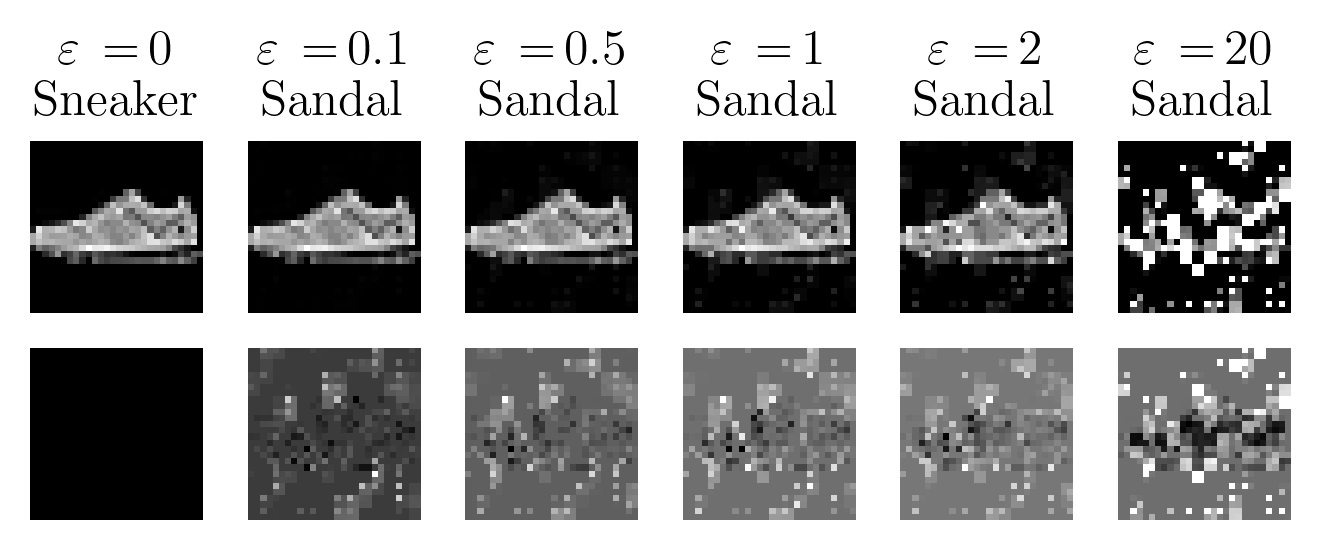

In [20]:
model = ResNet(
        in_channels=1,
        n_classes=10,
        device=device
    )
name_model = "resnet.pt" 
model.load_state_dict(torch.load(name_model, weights_only=True, map_location=device))
model.eval();


perturbation_list = [0,0.1,0.5,1,2,20]
image, target = next(iter(test_loader))

number = np.random.randint(len(image))
image, target = image[number:number+1].to(device), target[number:number+1].to(device)
loss_fn = lambda yhat, y: F.cross_entropy(yhat,y)
n_iter = 100
images = []
predictions = []
for epsilon in perturbation_list:
    images.append(l2_pgd_attack(model, image, target, loss_fn, epsilon, n_iter))
    outputs = model(images[-1])
    _, predicted = torch.max(outputs, 1)
    predictions.append(class_names[predicted])

plt.rcParams["figure.figsize"] = (4.5, 2)
fig, axes = plt.subplots(2, len(perturbation_list))
#plt.subplots_adjust(hspace=-0.7)

# Show the first 5 images and set their titles to the corresponding labels
for i in range(len(perturbation_list)):
    ax = axes[0,i]
    img = images[i]
    ax.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')
    ax.set_title(fr"$\varepsilon\,=\,${perturbation_list[i]}""\n"f"{predictions[i]}")
    ax.axis('off')  # Hide the axes
    ax = axes[1,i]
    img = images[i] - images[0]
    ax.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')
    ax.axis('off')  # Hide the axes
    
# Display the figure
plt.tight_layout()
plt.savefig("attacks.pdf",bbox_inches="tight")
plt.show()

The code below allows to attack the previously trained model with 8 attacks of magnitudes stored in the list `epsilons`.

In [ ]:
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]
robust_accuracy = get_robust_accuracies(model,epsilons,n_iter=100)

# Get robustness comparison as in the chapter

The code below simply aims to generate the robustness comparison of a pre-trained ResNet and Non-Expansive network. The paths of the trained models could be replaced with newly trained networks to get a different comparison.

Attacking the ResNet


Completed attack with epsilon=0.0, with accuracy 89.0
Completed attack with epsilon=0.03137254901960784, with accuracy 84.0
Completed attack with epsilon=0.06274509803921569, with accuracy 79.2
Completed attack with epsilon=0.1411764705882353, with accuracy 58.6
Completed attack with epsilon=0.3, with accuracy 18.7
Completed attack with epsilon=0.5, with accuracy 1.6
Completed attack with epsilon=0.6, with accuracy 0.1
Completed attack with epsilon=0.8, with accuracy 0.0
Completed attack with epsilon=1.0, with accuracy 0.0


 Attacking the Non-Expansive Network


Completed attack with epsilon=0.0, with accuracy 87.6
Completed attack with epsilon=0.03137254901960784, with accuracy 85.4
Completed attack with epsilon=0.06274509803921569, with accuracy 83.9
Completed attack with epsilon=0.1411764705882353, with accuracy 77.9
Completed attack with epsilon=0.3, with accuracy 62.9
Completed attack with epsilon=0.5, with accuracy 44.1
Completed attack with epsilon=0.6, w

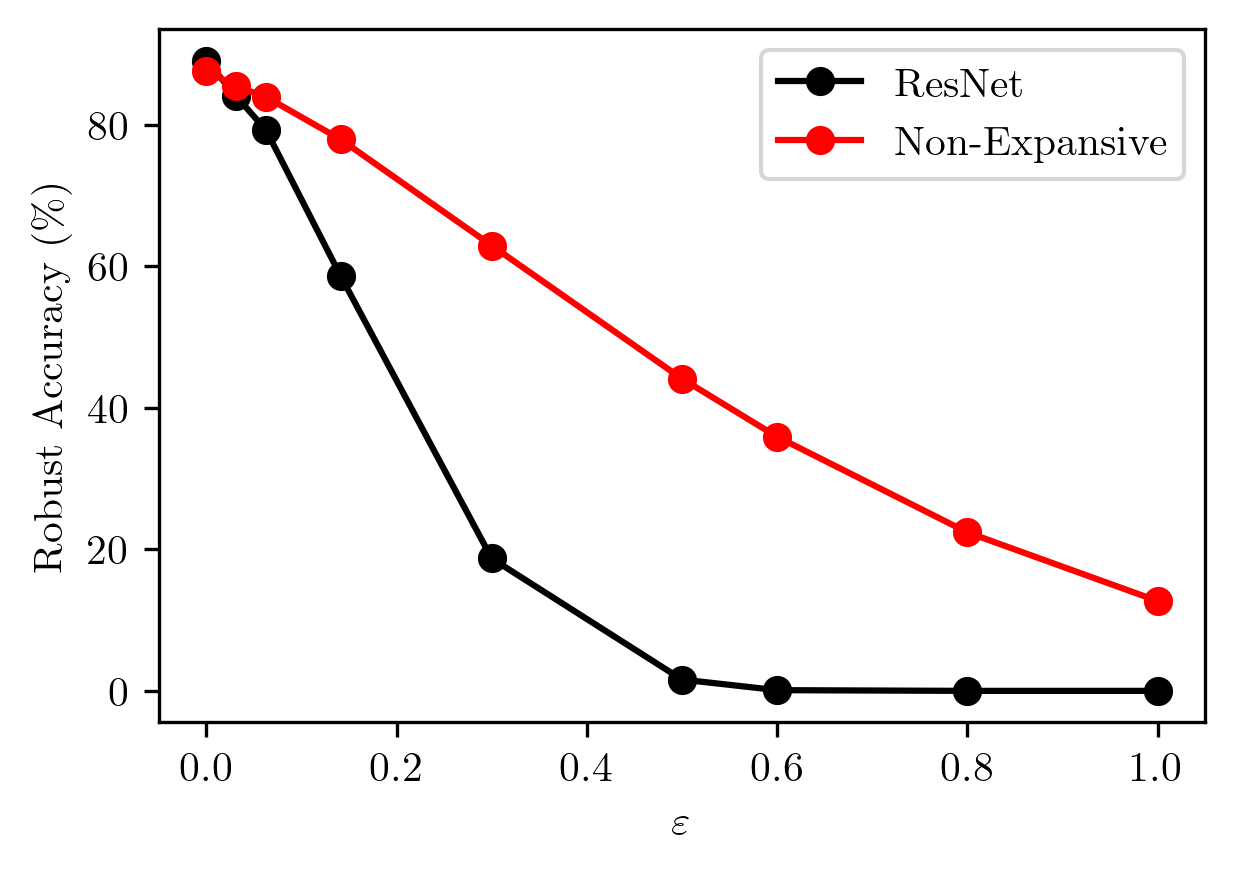

In [19]:
def compare_robustness(name_model_resnet="resnet.pt",name_model_nonexpansive="nonexpansive.pt"):

    resnet = ResNet(
            in_channels=1,
            n_classes=10,
            device=device
        )
    name_model = name_model_resnet 
    resnet.load_state_dict(torch.load(name_model, weights_only=True, map_location=device))
    resnet.eval();

    nonexpansive = NonExpansiveNet(
            in_channels=1,
            n_classes=10,
            device=device
        )
    name_model = name_model_nonexpansive 
    nonexpansive.load_state_dict(torch.load(name_model, weights_only=True, map_location=device))
    nonexpansive.updateScalings(k=100)
    nonexpansive.eval();

    epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]

    print("Attacking the ResNet\n\n")
    robust_accuracy_resnet = get_robust_accuracies(resnet,epsilons,n_iter=100)
    print("\n\n Attacking the Non-Expansive Network\n\n")
    robust_accuracy_nonexpansive = get_robust_accuracies(nonexpansive,epsilons,n_iter=100)

    plt.rcParams["figure.figsize"] = (4.5, 3)
    fig = plt.figure()
    plt.plot(epsilons,robust_accuracy_resnet,'-ko',label="ResNet")
    plt.plot(epsilons,robust_accuracy_nonexpansive,'-ro',label="Non-Expansive")

    plt.legend();
    plt.xlabel(r"$\varepsilon$")
    plt.ylabel("Robust Accuracy (\%)")
    plt.savefig(f"robust_accuracy.pdf",bbox_inches="tight")

compare_robustness(name_model_resnet="resnet.pt",name_model_nonexpansive="nonexpansive.pt") #replace names with new models in case you want to test newly trained ones